# Deep Learning Bootcamp: PyTorch Deep Neural Networks from Ground Up

In this notebook, we will start with the foundational blocks of Neural Networks and progressively delve into more complex architectures and techniques. 

We will use the CIFAR-10 dataset to experiment with building, optimizing, and tuning Deep Learning models to tackle image classification tasks. 

## Setting Up the Environment
Let's set up our environment by importing the necessary libraries and checking for GPU availability. If a GPU is not available, the training process will default to the CPU.

> conda create --name jads_bootcamp python=3.11
> 
> conda activate jads_bootcamp
>
> pip install -r requirements.txt

Follow the instruction in [Installing PyTorch](https://pytorch.org/get-started/locally/) to install Pytorch in the most appropriate way for your PC configuration.

Navigate to the directory containing the .ipynb file and run jupyter notebook:
> jupyter notebook

In [1]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
from itertools import product

# Fix HTTPS certificate error
import ssl
ssl_create_default_https_context = ssl._create_unverified_context

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Reproducibility
Achieving reproducible results is a cornerstone of scientific research. 

In the context of Deep Learning, this means ensuring that a model will produce the same results on the same data, regardless of when or where it is run. This is challenging due to the inherent randomness in model initialization and data shuffling. 
To avoid (or minimize) it, we fix the random seed across all libraries that generate random numbers.


In [2]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)
    
    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Numpy RNG
    np.random.seed(seed)
    
    # OS RNG
    os.environ['PYTHONHASHSEED'] = str(seed)

def worker_init_fn(worker_id):    
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
set_seed(42)  

## Hyperparameters
Hyperparameters are the configuration settings used to structure the learning process. 

In our case, we include settings on the learning rate, the batch size, the number of training epochs, and the size of the dataset for training. Adjusting these parameters can significantly affect the model's performance and the learning efficiency


In [3]:
# Hyperparameters
batch_size = 128
dataset_size = 5000  # Reduced dataset size for quicker training

epochs = 50
learning_rate = 0.001

## Dataset
We use the CIFAR-10 dataset, consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class. 

The dataset is divided into 50,000 training images and 10,000 test images. 

To speed up the training process, we reduce the number of training images to 10,000.


In [4]:
transform = transforms.Compose([
    transforms.ToTensor() # Convert images to tensors
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Reducing the dataset size 
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

print(f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Full train set size: 50000 - Reduced train set size: 5000 - Test set size: 10000


<span style="font-size:smaller;">

#### Code Breakdown
    
```python
transform = transforms.Compose([
    transforms.ToTensor() # Convert images to tensors
])
```

**Transforms:** Data transformations are crucial in Deep Learning for preprocessing and augmenting your data. Here, `transforms.Compose` allows us to chain together different transformations. `transforms.ToTensor()` converts images into PyTorch tensors, automatically scaling the image data to the range [0, 1].

```python
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
```

**Loading CIFAR10:** These lines load the CIFAR10 dataset for training and testing. The `train` parameter specifies whether to load the training subset (True) or the test subset (False). `download=True` will download the data to the `root` directory if it's not already present. The `transform` argument applies the specified transformations to the dataset.

```python
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)
```

**Dataset Reduction:** To speed up training for educational purposes, we might want to work with a smaller subset of the data. This is achieved by creating a list of `indices` that define the subset and then using `Subset` to extract those specific samples from the full dataset.

```python
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
```

**Data Loaders:** The `DataLoader` wraps a dataset and provides an iterable over the dataset. The `batch_size` defines how many samples per batch to load. `shuffle=True` shuffles the data every epoch, ensuring the model doesn't learn anything from the order of the samples. The `worker_init_fn` can be used for reproducibility of the data loading process, especially when using random transformations.
</span>

### Normalize the inputs

Let's normalize the input data, to improve the learning process, by using Standard Normalization.
we first need to calculate the mean and variance of the pixel values across the entire training dataset. These statistics are then used to normalize both the training and validation/test datasets. 

In [5]:
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0

    for images, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0) 
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images

    return mean, variance

# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([0.4913, 0.4814, 0.4445])
Standard Deviation: tensor([0.2124, 0.2098, 0.2133])


Let's add the input normalization

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize images
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Reducing the dataset size 
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

print(f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Full train set size: 50000 - Reduced train set size: 5000 - Test set size: 10000


<span style="font-size:smaller;">

#### Code breakdown

```python
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize images
])
```

**Normalization:** After converting the images into tensors, `transforms.Normalize(mean=mean, std=std)` standardizes the pixel values across the dataset. This normalization process adjusts the pixel values so that they have a smean of 0 and a standard deviation of 1.

</span>

## Input Visualization
Let's take a look to some of our input images

Label: cat


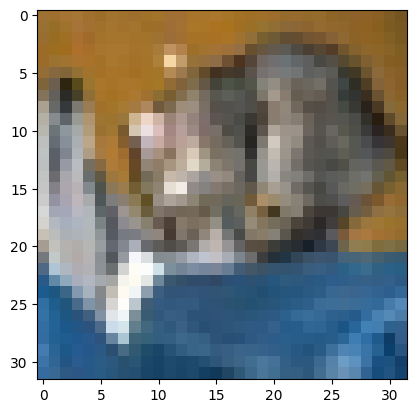

Label: ship


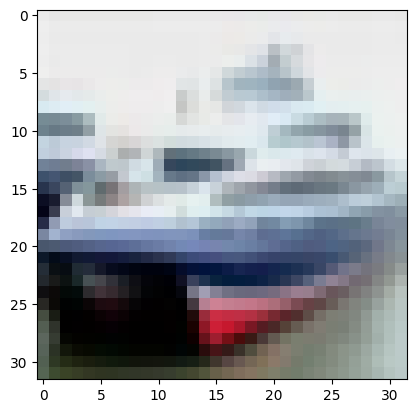

Label: ship


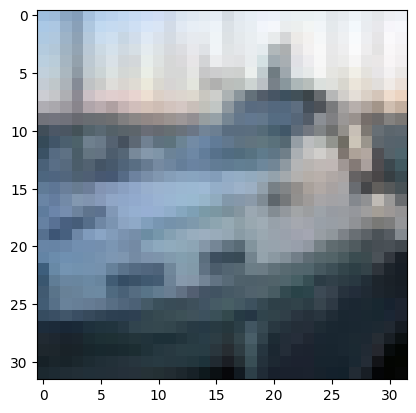

Label: plane


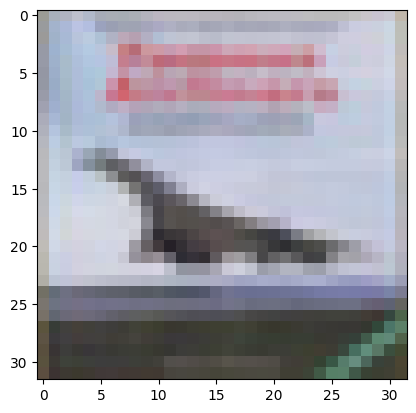

Label: frog


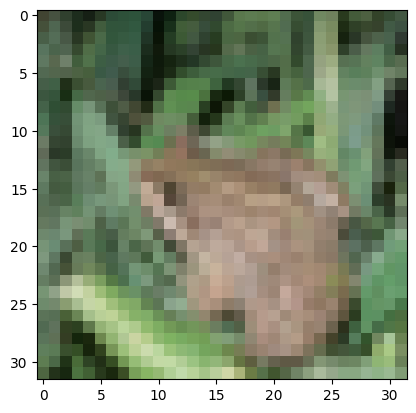

In [7]:
num_images = 5

def denormalize(img, mean, std):
    """Denormalizes an image to its original form using mean and std"""
    mean = torch.tensor(mean).reshape(-1, 1, 1) if not isinstance(mean, torch.Tensor) else mean.reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1) if not isinstance(std, torch.Tensor) else std.reshape(-1, 1, 1)
    denorm_img = img * std + mean  # Apply denormalization
    return denorm_img
    
def imshow(img, mean, std):
    """Shows an image by first denormalizing it"""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 255)  # Ensure the image is within [0, 255]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Select random images and plot them with labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Display the images with denormalization
for i in range(num_images):
    image, label = test_dataset[i][0], test_dataset[i][1]  # Ensure that you're accessing the tensor image
    print('Label:', classes[label])
    imshow(image, mean, std)  # Pass mean and std as tensors

## Basic Neural Network Architecture

Let's start our exploration with a basic Linear Model to establish a performance baseline. 

This model, consisting of a single linear layer, is quick to train but typically underperforms on complex tasks due to its inability to capture non-linear relations in the training data.

In PyTorch, the layers come with a default weight initialization. Let's use them in this first training iteration.


In [8]:
# Linear Model
class Linear_Model(nn.Module):
    def __init__(self):
        super(Linear_Model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(3*32*32, 10),            
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

linear_model = Linear_Model().to(device)
print(linear_model)

Linear_Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
  )
)


<span style="font-size:smaller;">

#### Code breakdown

Let's examine the structure of a basic linear model:

1. **Base Class Inheritance (`nn.Module`):** In PyTorch, all neural network modules should inherit from `nn.Module`. This base class helps in organizing the network, and it provides essential functionalities for training and inference.

2. **Initialization Method (`__init__`):** This method initializes the layers of our linear model. Our model consists of two main parts:
   - `nn.Flatten()`: This layer flattens the input tensors. For an image dataset like CIFAR10, which consists of 3x32x32 images (3 channels, 32x32 pixels), flattening transforms each image into a 1D tensor of 3*32*32 = 3072 elements. Flattening is a common preprocessing step before feeding data into a linear layer.
   - `nn.Linear(3*32*32, 10)`: The linear layer, or fully connected layer, maps the flattened input to the output. Here, it maps from 3072 input features to 10 output features, corresponding to the 10 classes of the CIFAR10 dataset. This layer will learn the weights and biases during training.

3. **Forward Method (`forward`):** This method defines how the input `x` flows through the model. First, we flatten the input, and then we pass it through the linear layer. The output `logits` represents the raw predictions that our model makes, which can then be passed through a softmax function for classification tasks.

4. **Model Instantiation and Device Allocation:** `linear_model = Linear_Model().to(device)` creates an instance of our linear model and moves it to a device (CPU or GPU), allowing for accelerated computation. The `print(linear_model)` statement displays the architecture of our model, helping us verify its structure.

</span>

How many parameters do the model have?

In [9]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in linear_model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: linear_stack.0.weight, Parameters: 30720
Layer: linear_stack.0.bias, Parameters: 10

Total number of parameters: 30730


## Loss function and optimizer

When choosing a loss function and an optimizer for a neural network, it's important to consider the specific task at hand. 

For classification tasks, Cross Entropy Loss and optimizers like SGD or Adam are common choices. 

In [10]:
model = linear_model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

<span style="font-size:smaller;">

#### Code Breakdown

**Loss Function (Criterion):**
- `criterion = nn.CrossEntropyLoss()`: The loss function measures how well the model performs on the given dataset. For classification tasks, **CrossEntropyLoss** is commonly used. It combines **softmax** (a function that converts logits to probabilities) with **log loss** (negative log likelihood), effectively dealing with multi-class classification problems. This function expects raw output from the model (logits) and calculates the difference between the predicted probabilities and the actual class labels.

**Optimizer:**
- `optimizer = optim.SGD(model.parameters(), lr=learning_rate)`: The optimizer updates the model's parameters (weights and biases) using the gradients computed during backpropagation. Here, we use **Stochastic Gradient Descent (SGD)** as our optimizer. `model.parameters()` tells the optimizer which parameters to adjust, and `lr=learning_rate` sets the step size for each iteration during optimization. The learning rate is a critical hyperparameter that controls how much we are adjusting the weights of our network concerning the loss gradient. Too small a learning rate may result in slow convergence, while too large a learning rate can cause the model to oscillate or even diverge.

</span>

## Model Training

The training loop is where the model learns from the data. In each epoch, the model makes predictions, calculates the error (loss), and uses backpropagation to adjust the weights. 

### Training Process Overview

During training, for each batch of data, the following steps occur:
1. **Forward Pass:** The model computes predictions based on the input data.
2. **Compute Loss:** The difference between the predictions and the actual labels is calculated using the loss function.
3. **Backward Pass:** The model backpropagates the loss to compute the gradients of the loss with respect to each parameter.
4. **Update Parameters:** The optimizer uses the gradients calculated during the backward pass to update the model's parameters.

In [11]:
# Training and Validation Loop
for epoch in tqdm(range(epochs)):
    # Training Phase
    model.train()  # Set the model to training mode
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.12s/it]


### Model Training with Validation Loop

Using the previous training loop is not a smart choice because it lacks the following critical components for training a neural network effectively:

1. **Logging and Monitoring**: Logging training metrics such as losses, and accuracy, is crucial for tracking the model's performance over time. Without proper logging and monitoring, it becomes challenging to diagnose issues, compare different models, or make informed decisions about model improvements.

1. **Validation Step**: the previous training loop misses a validation step after each epoch. Validating the model on a separate validation dataset is essential to monitor its generalization performance and detect overfitting. Without validation, it's difficult to determine if the model is learning to generalize well beyond the training data.

Let's address these issues.

In [12]:
# Lists to store metrics
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

# Training and Validation Loop
start_time = time.time()
for epoch in range(epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model
        
        train_loss += loss.item() * images.size(0)  # Accumulate the loss
        _, predicted = torch.max(outputs, 1)  # Get predictions
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()  # Calculate correct predictions
  
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            
            validation_loss += loss.item() * images.size(0)  # Accumulate the loss
            _, predicted = torch.max(outputs, 1)  # Get predictions
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()  # Calculate correct predictions
    
    validation_loss /= len(test_loader.dataset)
    validation_accuracy = 100 * correct_val / total_val
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    # Print metrics
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

end_time = time.time()
execution_time = end_time - start_time

minutes = int(execution_time // 60)  
seconds = int(execution_time % 60)   
print(f"\nExecution time: {minutes:02}:{seconds:02}")

Epoch [1/50], Training Loss: 1.5945, Training Accuracy: 46.64%, Validation Loss: 1.8458, Validation Accuracy: 36.21%
Epoch [2/50], Training Loss: 1.5929, Training Accuracy: 46.68%, Validation Loss: 1.8414, Validation Accuracy: 36.73%
Epoch [3/50], Training Loss: 1.5890, Training Accuracy: 47.00%, Validation Loss: 1.8402, Validation Accuracy: 36.64%
Epoch [4/50], Training Loss: 1.5863, Training Accuracy: 47.64%, Validation Loss: 1.8420, Validation Accuracy: 36.32%
Epoch [5/50], Training Loss: 1.5836, Training Accuracy: 47.40%, Validation Loss: 1.8472, Validation Accuracy: 36.11%
Epoch [6/50], Training Loss: 1.5830, Training Accuracy: 47.18%, Validation Loss: 1.8405, Validation Accuracy: 36.53%
Epoch [7/50], Training Loss: 1.5790, Training Accuracy: 47.50%, Validation Loss: 1.8400, Validation Accuracy: 36.63%
Epoch [8/50], Training Loss: 1.5757, Training Accuracy: 47.42%, Validation Loss: 1.8407, Validation Accuracy: 36.49%
Epoch [9/50], Training Loss: 1.5735, Training Accuracy: 47.48%, 

## Metrics and Plotting

Let's plot training set and validation set loss, and accuracy.

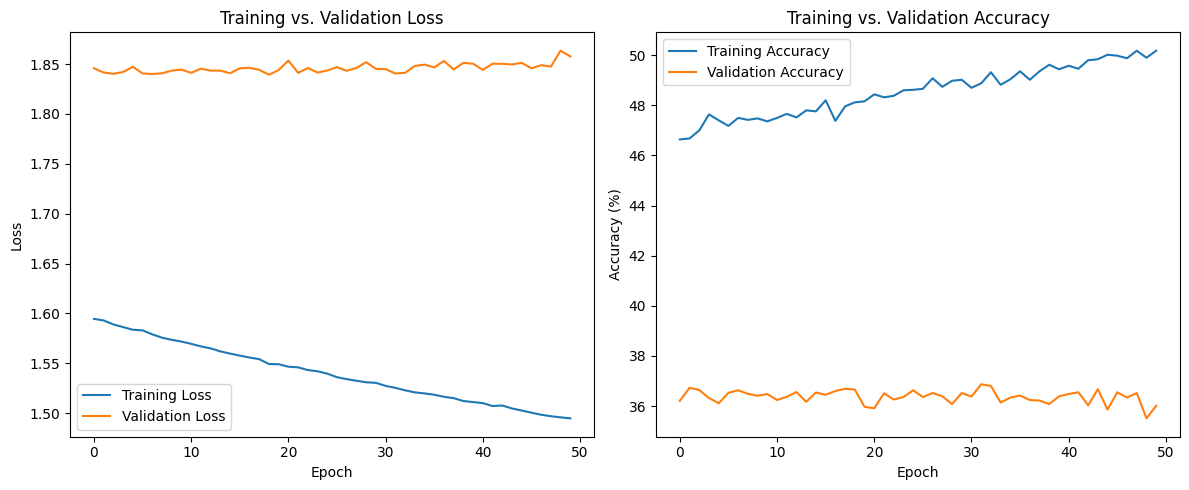

In [13]:
# Plotting Training vs. Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Let's refactor your code into two distinct functions, one for the training and validation loop and another for plotting the metrics, to re-utilize them more easily.

In [11]:
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    start_time = time.time()
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation Phase
        model.eval()
        validation_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                validation_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        validation_loss /= len(test_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    
    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f"\nExecution time: {minutes:02}:{seconds:02}")
    
    return train_losses, train_accuracies, validation_losses, validation_accuracies

def plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Underfitting
Due to its simplicity, the linear model has limited expressive power and lacks the capacity to learn the distinctions between different classes. effectively.

Let's define a DNN model by introducing hidden layers with non-linear activation functions (ReLU in this case) to increase the model's capacity to learn complex patterns

While PyTorch automatically applies proper layer initialization by default, let's explicitly set the weight initialization in this specific case.

In [15]:
# DNN Model
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

        # Initialize weights using He initialization explicitly
        for layer in self.modules():
            # Applies He initialization to each linear layer
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                
                # Initialize biases to zero
                if layer.bias is not None:
                    init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

dnn_model = DNN().to(device)
print(dnn_model)

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=10, bias=True)
  )
)


<span style="font-size:smaller;">

#### Code Breakdown

We now turn our attention to a more complex model than the linear one we previously discussed.

```python
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            ...
            nn.Linear(64, 10)
        )
```

- **Dense Layers with Activation:** The `self.linear_relu_stack` is a sequence of linear layers (`nn.Linear`) interspersed with ReLU activation functions (`nn.ReLU`). This stack transforms the flattened input from 3072 dimensions down to 10 dimensions, corresponding to our class labels.

##### Weight Initialization

```python
for layer in self.modules():
    if isinstance(layer, nn.Linear):
        init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
            init.constant_(layer.bias, 0)
```

- **He Initialization:** This loop iterates through all modules in our model. When it finds a linear layer, it applies He (also known as Kaiming) initialization to the layer's weights. This initialization strategy is designed for layers followed by ReLU activations and helps in maintaining the variance of activations across layers, promoting efficient learning. Biases are set to zero as a starting point, ensuring a neutral starting bias for each neuron.

</span>

How many parameters do the model have?

In [16]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in dnn_model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: linear_relu_stack.0.weight, Parameters: 3145728
Layer: linear_relu_stack.0.bias, Parameters: 1024
Layer: linear_relu_stack.2.weight, Parameters: 524288
Layer: linear_relu_stack.2.bias, Parameters: 512
Layer: linear_relu_stack.4.weight, Parameters: 131072
Layer: linear_relu_stack.4.bias, Parameters: 256
Layer: linear_relu_stack.6.weight, Parameters: 32768
Layer: linear_relu_stack.6.bias, Parameters: 128
Layer: linear_relu_stack.8.weight, Parameters: 8192
Layer: linear_relu_stack.8.bias, Parameters: 64
Layer: linear_relu_stack.10.weight, Parameters: 640
Layer: linear_relu_stack.10.bias, Parameters: 10

Total number of parameters: 3844682


Let's use the same training pipeline we used earlier

Epoch [1/50], Training Loss: 11.8862, Training Accuracy: 16.56%, Validation Loss: 7.3715, Validation Accuracy: 17.66%
Epoch [2/50], Training Loss: 4.5790, Training Accuracy: 23.58%, Validation Loss: 4.6142, Validation Accuracy: 19.35%
Epoch [3/50], Training Loss: 3.1258, Training Accuracy: 28.56%, Validation Loss: 4.0519, Validation Accuracy: 19.93%
Epoch [4/50], Training Loss: 2.5094, Training Accuracy: 33.28%, Validation Loss: 3.9044, Validation Accuracy: 20.51%
Epoch [5/50], Training Loss: 2.1553, Training Accuracy: 37.74%, Validation Loss: 3.5179, Validation Accuracy: 22.06%
Epoch [6/50], Training Loss: 1.8758, Training Accuracy: 42.68%, Validation Loss: 3.5169, Validation Accuracy: 22.70%
Epoch [7/50], Training Loss: 1.6948, Training Accuracy: 46.74%, Validation Loss: 3.4739, Validation Accuracy: 22.66%
Epoch [8/50], Training Loss: 1.5314, Training Accuracy: 51.02%, Validation Loss: 3.3925, Validation Accuracy: 22.81%
Epoch [9/50], Training Loss: 1.4073, Training Accuracy: 55.02%,

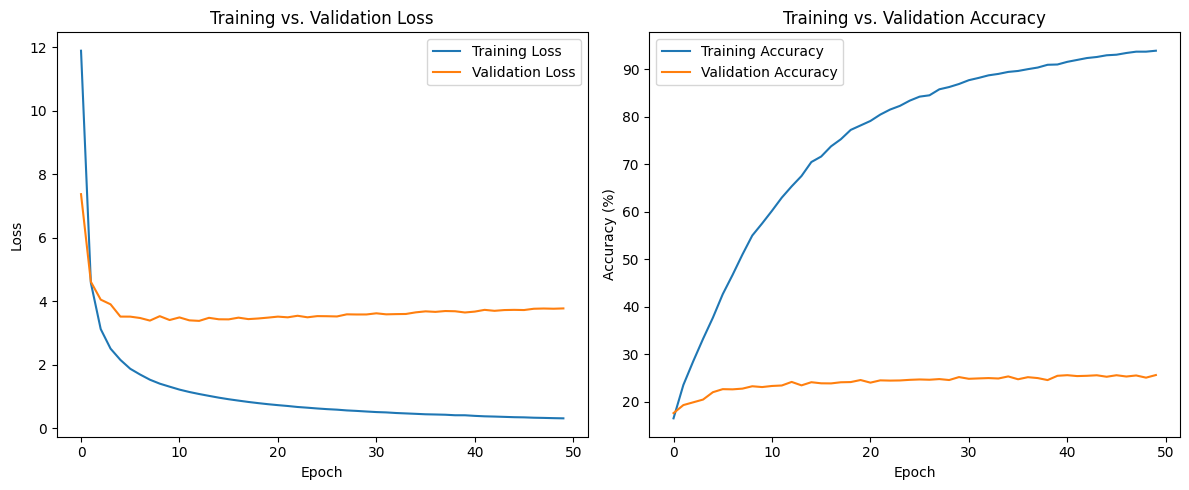

In [17]:
model = dnn_model
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

## Improve the Optimizer choice

Can we converge faster?
Let's change the optimizer and use Adam optimizer!

An alternative to SGD, the Adam optimizer, combines the benefits of two extensions of Stochastic Gradient Descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). Adam computes adaptive learning rates for each parameter. 

In practice, Adam is often recommended as the default optimizer for many types of neural networks because it requires minimal tuning.

For many tasks, Adam converges faster than SGD due to its adaptive learning rate properties.

Epoch [1/50], Training Loss: 13.4155, Training Accuracy: 19.44%, Validation Loss: 5.7094, Validation Accuracy: 24.06%
Epoch [2/50], Training Loss: 4.0456, Training Accuracy: 28.02%, Validation Loss: 4.3829, Validation Accuracy: 25.28%
Epoch [3/50], Training Loss: 2.6601, Training Accuracy: 35.60%, Validation Loss: 3.0440, Validation Accuracy: 28.49%
Epoch [4/50], Training Loss: 1.9759, Training Accuracy: 43.22%, Validation Loss: 2.7020, Validation Accuracy: 27.45%
Epoch [5/50], Training Loss: 1.5852, Training Accuracy: 50.40%, Validation Loss: 2.4492, Validation Accuracy: 33.75%
Epoch [6/50], Training Loss: 1.2633, Training Accuracy: 58.76%, Validation Loss: 2.5863, Validation Accuracy: 31.63%
Epoch [7/50], Training Loss: 1.0939, Training Accuracy: 64.32%, Validation Loss: 2.6484, Validation Accuracy: 32.24%
Epoch [8/50], Training Loss: 1.1961, Training Accuracy: 64.32%, Validation Loss: 2.5700, Validation Accuracy: 34.20%
Epoch [9/50], Training Loss: 1.0879, Training Accuracy: 65.74%,

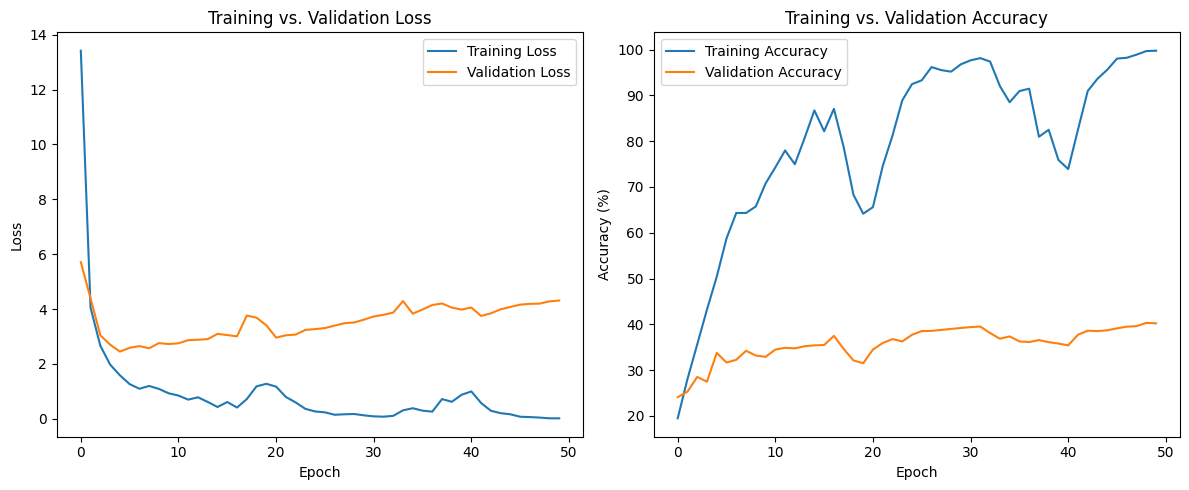

In [18]:
model = DNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

## Regularization
We are overfitting! Let's try to regularize our model.
We will try to implement both L2 Regularization and Dropout. 

- **L2 regularization** is added through the optimizer, by setting the `weight_decay` parameter, which applies to all the parameters of the model. 
- **Dropout** is included within the model definition, by adding nn.Dropout layers in the sequential model where appropriate.

### L2 Regularization 
L2 regularization, also known as weight decay, adds a penalty on the size of the weights, encouraging them to be small.

When you define your optimizer, you can specify the `weight_decay` parameter to enable L2 regularization. The value of weight_decay determines the strength of the regularization. A common choice is to start experimenting with values like 1e-5 to 1e-4:

```python
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
```

Epoch [1/50], Training Loss: 12.6914, Training Accuracy: 17.26%, Validation Loss: 6.4605, Validation Accuracy: 19.17%
Epoch [2/50], Training Loss: 3.5935, Training Accuracy: 25.06%, Validation Loss: 2.7489, Validation Accuracy: 20.81%
Epoch [3/50], Training Loss: 2.0894, Training Accuracy: 31.24%, Validation Loss: 2.3424, Validation Accuracy: 24.23%
Epoch [4/50], Training Loss: 1.7087, Training Accuracy: 40.08%, Validation Loss: 2.3958, Validation Accuracy: 27.95%
Epoch [5/50], Training Loss: 1.6380, Training Accuracy: 43.70%, Validation Loss: 2.4831, Validation Accuracy: 28.17%
Epoch [6/50], Training Loss: 1.4954, Training Accuracy: 48.58%, Validation Loss: 2.5244, Validation Accuracy: 29.68%
Epoch [7/50], Training Loss: 1.3852, Training Accuracy: 52.40%, Validation Loss: 2.4072, Validation Accuracy: 30.90%
Epoch [8/50], Training Loss: 1.3960, Training Accuracy: 52.94%, Validation Loss: 2.6299, Validation Accuracy: 26.87%
Epoch [9/50], Training Loss: 1.3378, Training Accuracy: 55.44%,

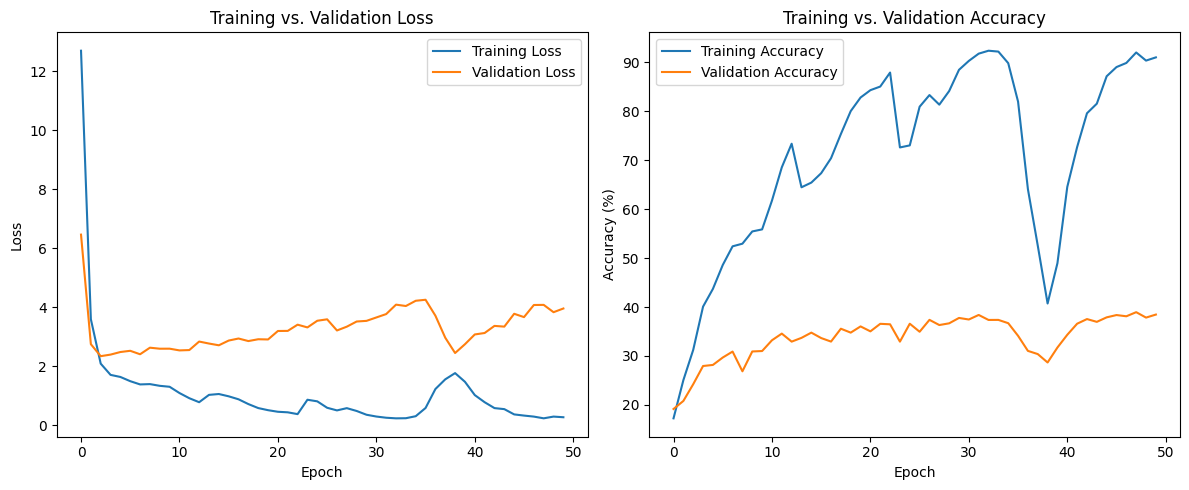

In [19]:
model = DNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # Added L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

### Dropout Regularization
Dropout is a technique used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time, which helps to prevent neurons from co-adapting too much.

Dropout is included within the model definition, by adding `nn.Dropout layers`.

In [20]:
# DNN Model
class DNN_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DNN_Dropout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

dnn_dropout_model = DNN_Dropout().to(device)
print(dnn_dropout_model)

DNN_Dropout(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=64, out_features=10, bias=True)
  )
)


<span style="font-size:smaller;">

#### Code Breakdown

Let's examine the `DNN_Dropout` class, a variant of our previous DNN model that incorporates dropout layers.

```python
    def __init__(self, dropout_rate=0.5):
        
        [...]
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            ...
            nn.Linear(64, 10)
        )
```

- **Dropout Introduction:** The primary difference in this model, compared to the previous DNN module, is the addition of `nn.Dropout(dropout_rate)` layers. Dropout is a regularization technique that temporarily drops units (along with their connections) from the network during training, which helps prevent the network from becoming too dependent on any single neuron. This randomness encourages the network to learn more robust features that generalize better to unseen data.

- **Dropout Rate:** The `dropout_rate` parameter specifies the probability of an element to be zeroed. A common choice is `0.5`, meaning there's a 50% chance each neuron's output will be ignored during each forward pass in training. This rate can be adjusted to balance between underfitting and overfitting.

</span>

Epoch [1/50], Training Loss: 2.2893, Training Accuracy: 12.86%, Validation Loss: 2.1757, Validation Accuracy: 18.63%
Epoch [2/50], Training Loss: 2.1837, Training Accuracy: 18.58%, Validation Loss: 2.0771, Validation Accuracy: 23.66%
Epoch [3/50], Training Loss: 2.1161, Training Accuracy: 20.74%, Validation Loss: 2.0289, Validation Accuracy: 24.77%
Epoch [4/50], Training Loss: 2.0682, Training Accuracy: 22.32%, Validation Loss: 1.9703, Validation Accuracy: 25.89%
Epoch [5/50], Training Loss: 2.0422, Training Accuracy: 22.90%, Validation Loss: 1.9393, Validation Accuracy: 28.52%
Epoch [6/50], Training Loss: 2.0071, Training Accuracy: 25.10%, Validation Loss: 1.9586, Validation Accuracy: 27.43%
Epoch [7/50], Training Loss: 1.9684, Training Accuracy: 24.70%, Validation Loss: 1.8837, Validation Accuracy: 29.76%
Epoch [8/50], Training Loss: 1.9433, Training Accuracy: 26.96%, Validation Loss: 1.8884, Validation Accuracy: 28.71%
Epoch [9/50], Training Loss: 1.9334, Training Accuracy: 26.98%, 

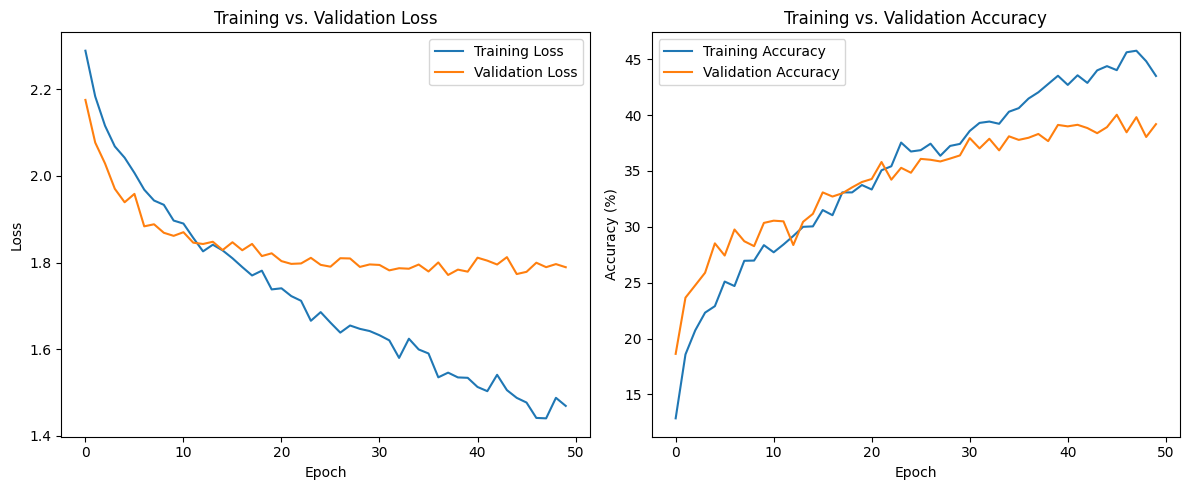

In [21]:
model = DNN_Dropout().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # NO L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

..and now??

We have solved the over-fitting problem, but now we are under-fitting again! What to do?

Can we improve the model?

In [22]:
# DNN Model with Batch Normalization
class DNN_BatchNorm(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(DNN_BatchNorm, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.BatchNorm1d(1024),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),   # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),   # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),   # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),    # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

dnn_batchnorm_model = DNN_BatchNorm().to(device)
print(dnn_batchnorm_model)

DNN_BatchNorm(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17):

<span style="font-size:smaller;">

#### Code Breakdown

```python
        self.linear_stack = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.BatchNorm1d(1024),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            ...
            nn.Linear(64, 10)
        )
```

- **Batch Normalization Layers:** After each linear layer (except the final one), a `nn.BatchNorm1d` layer is added. Batch Normalization normalizes the output of the previous layer by subtracting the batch mean and dividing by the batch standard deviation. This process stabilizes the learning process, accelerates the training speed, and often leads to better overall performance by reducing internal covariate shift.

</span>

Epoch [1/50], Training Loss: 2.1103, Training Accuracy: 24.40%, Validation Loss: 1.9455, Validation Accuracy: 32.12%
Epoch [2/50], Training Loss: 1.8813, Training Accuracy: 32.62%, Validation Loss: 1.8267, Validation Accuracy: 34.12%
Epoch [3/50], Training Loss: 1.7670, Training Accuracy: 35.74%, Validation Loss: 1.7712, Validation Accuracy: 36.93%
Epoch [4/50], Training Loss: 1.6865, Training Accuracy: 40.30%, Validation Loss: 1.7368, Validation Accuracy: 37.73%
Epoch [5/50], Training Loss: 1.6029, Training Accuracy: 43.26%, Validation Loss: 1.7005, Validation Accuracy: 38.99%
Epoch [6/50], Training Loss: 1.5588, Training Accuracy: 44.36%, Validation Loss: 1.6655, Validation Accuracy: 40.87%
Epoch [7/50], Training Loss: 1.5123, Training Accuracy: 46.56%, Validation Loss: 1.6860, Validation Accuracy: 40.92%
Epoch [8/50], Training Loss: 1.4882, Training Accuracy: 47.54%, Validation Loss: 1.6702, Validation Accuracy: 41.18%
Epoch [9/50], Training Loss: 1.3940, Training Accuracy: 50.92%, 

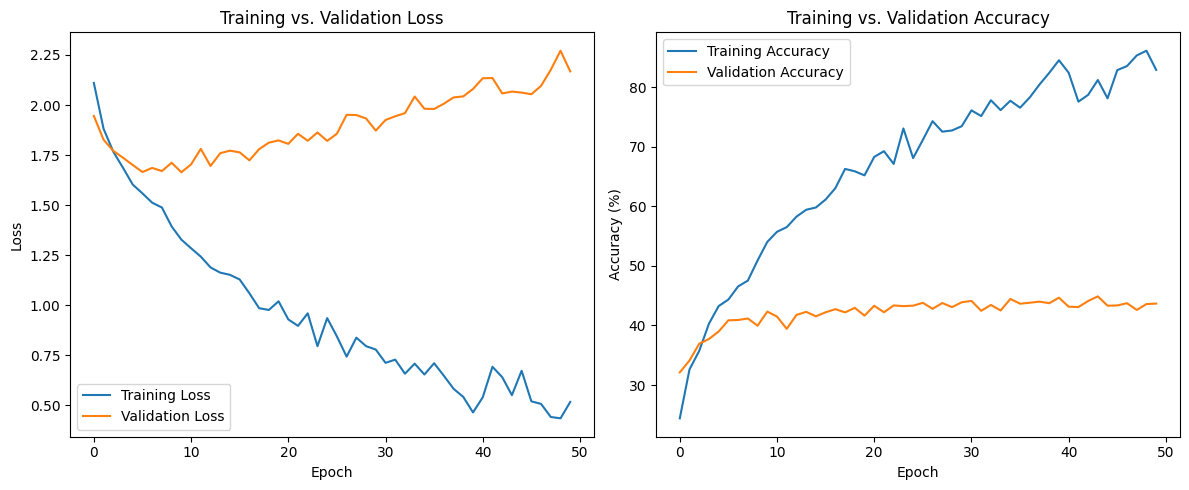

In [23]:
model = DNN_BatchNorm().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # NO L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

## Hyperparameter search
When embarking on a Deep Learning project, one of the most critical steps after designing your model is hyperparameter tuning. 

Hyperparameters significantly influence model performance, and their optimal combination can vary widely between datasets and problem types. 

In [27]:
def train_validate_model(params, device):
    print(params)
    print()
    
    # Unpack parameters
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Prepare data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Model, criterion, and optimizer setup
    model = DNN_Dropout(dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Use the previously implemented function for training and validation
    train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
        model, train_loader, test_loader, criterion, optimizer, epochs, device
    )

    # Optional: Return more detailed training/validation outcomes
    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "validation_losses": validation_losses,
        "validation_accuracies": validation_accuracies,
        "best_validation_accuracy": max(validation_accuracies)  # Assumes validation_accuracies is not empty
    }

<span style="font-size:smaller;">

#### Code Breakdown

With this single, parameterized function, we encapsulate model training and validation, to streamline the workflow, and quickly iterate over various hyperparameters.
</span>

## Define the hyperparameter grid


In [28]:
# Example hyperparameter grid
param_space = {
    'epochs': [20, 30, 50],
    'batch_size': [128, 64, 32],
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout_rate': [0.0, 0.2, 0.4, 0.6],
}

#### Code Breakdown

```python
param_space = {
    'epochs': [10, 20, 30],
    'batch_size': [128, 64, 32],
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout_rate': [0.0, 0.2, 0.4, 0.6],
}
```

- The `param_space` dictionary defines a hyperparameter space with multiple values for each key parameter, including the number of epochs, batch size, learning rate, weight decay, and dropout rate. 

## Implement grid search

Let's apply a structured approach for exploring a broad spectrum of hyperparameters using a **grid search** strategy. In a grid search, we systematically work through all the combinations of parameter values, cross-validating as we go to determine which tune yields the highest performance measure. 

- **Advantages:** This exhaustive search over specified parameter values provides a comprehensive overview of how different hyperparameters impact the performance, helping to identify the most promising configurations.

- **Challenges:** The primary challenge with grid search is its computational cost. As the number of hyperparameters and their potential values increases, the total number of configurations grows exponentially. This can make grid searches computationally expensive and time-consuming, especially when training deep learning models.

In [31]:
# Generate all combinations of hyperparameters
param_grid = list(product(*param_space.values()))

# Convert to list of dicts to facilitate passing to the training function
param_dicts = [dict(zip(param_space.keys(), combo)) for combo in param_grid]
print(f"Number of parameters combinations: {len(param_dicts)} \n")

best_accuracy = 0
best_params = None
best_model_metrics = None

for params in param_dicts:
    model_metrics = train_validate_model(params, device)
    validation_accuracy = model_metrics['validation_accuracies'][-1]
    print(f"Validation accuracy: {validation_accuracy}\n")
    
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_params = params
        best_model_metrics = model_metrics

    if best_accuracy > 0:
        print("\nIt looks like a very time and resource consuming strategy... \nLet's look for a smarter apporach!")
        break

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")

Number of parameters combinations: 324 

{'epochs': 20, 'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'dropout_rate': 0.0}

Epoch [1/20], Training Loss: 2.0147, Training Accuracy: 25.44%, Validation Loss: 1.9701, Validation Accuracy: 29.30%
Epoch [2/20], Training Loss: 1.8277, Training Accuracy: 32.54%, Validation Loss: 1.9000, Validation Accuracy: 32.32%
Epoch [3/20], Training Loss: 1.7513, Training Accuracy: 35.56%, Validation Loss: 1.8215, Validation Accuracy: 33.21%
Epoch [4/20], Training Loss: 1.6387, Training Accuracy: 40.24%, Validation Loss: 1.9017, Validation Accuracy: 32.00%
Epoch [5/20], Training Loss: 1.6822, Training Accuracy: 39.14%, Validation Loss: 1.8817, Validation Accuracy: 33.47%
Epoch [6/20], Training Loss: 1.6430, Training Accuracy: 40.00%, Validation Loss: 1.7394, Validation Accuracy: 37.97%
Epoch [7/20], Training Loss: 1.5108, Training Accuracy: 45.22%, Validation Loss: 1.8019, Validation Accuracy: 37.39%
Epoch [8/20], Training Loss: 1.5323, 

## Implement random search

Grid search is thorough and guarantees that you'll explore the entire specified parameter space, making it preferable when the search space is reasonably small and computational resources permit exhaustive search. 

Random search, is potentially more efficient in very large search spaces, but it might miss important combinations of parameters that could yield the best model performance.

In [32]:
def sample_hyperparameters(space):
    sampled_params = {}
    for k, v in space.items():
        sampled_params[k] = random.choice(v)
    return sampled_params

# Number of different models search for random search
num_searches = 10 

best_accuracy = 0
best_params = None
best_model_metrics = None

for n_search in range(num_searches):
    print(f"Search {n_search} out of {num_searches}")
    params = sample_hyperparameters(param_space)

    model_metrics = train_validate_model(params, device)
    validation_accuracy = model_metrics['validation_accuracies'][-1]
    print(f"Validation accuracy: {validation_accuracy}\n")
    
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_params = params
        best_model_metrics = model_metrics

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")

Search 0 out of 10
{'epochs': 50, 'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 1e-06, 'dropout_rate': 0.4}

Epoch [1/50], Training Loss: 2.1544, Training Accuracy: 20.68%, Validation Loss: 2.0006, Validation Accuracy: 27.37%
Epoch [2/50], Training Loss: 2.0153, Training Accuracy: 25.06%, Validation Loss: 1.9102, Validation Accuracy: 29.78%
Epoch [3/50], Training Loss: 1.9158, Training Accuracy: 28.56%, Validation Loss: 1.8378, Validation Accuracy: 31.82%
Epoch [4/50], Training Loss: 1.8865, Training Accuracy: 30.76%, Validation Loss: 1.7940, Validation Accuracy: 33.58%
Epoch [5/50], Training Loss: 1.8324, Training Accuracy: 32.56%, Validation Loss: 1.7864, Validation Accuracy: 35.01%
Epoch [6/50], Training Loss: 1.7951, Training Accuracy: 33.90%, Validation Loss: 1.7471, Validation Accuracy: 36.43%
Epoch [7/50], Training Loss: 1.7628, Training Accuracy: 34.90%, Validation Loss: 1.7348, Validation Accuracy: 36.65%
Epoch [8/50], Training Loss: 1.7139, Training Accuracy: 37.6

## CNN

Convolutional Neural Networks (CNNs) have revolutionized the field of image recognition. CNNs excel at capturing spatial relationships within image data through the use of convolutional filters. These filters allow CNNs to identify patterns and features at different spatial scales, making them particularly well-suited for tasks such as image classification.

In [12]:
class CNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1: 32x32x3 -> 16x16x32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2: 16x16x32 -> 8x8x64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=self.dropout_rate),
            nn.Linear(8*8*64, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layer(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=10

<span style="font-size:smaller;">

#### Code Breakdown

CNNs are a cornerstone of modern deep learning, especially in tasks related to images.

```python
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(CNN, self).__init__()
        ...
```

- **Class Initialization:** Also `CNN` class inherits from `nn.Module`, laying the foundation for all neural network modules in PyTorch. 

##### Convolutional Layers

```python
self.conv_layer = nn.Sequential(
    ...
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    ...
    nn.MaxPool2d(kernel_size=2, stride=2),
    ...
)
```

- **Convolutional Blocks:** The `conv_layer` is composed of sequential convolutional blocks, each containing a `nn.Conv2d` layer followed by batch normalization (`nn.BatchNorm2d`) and a ReLU activation function (`nn.ReLU`). These blocks are designed to extract spatial hierarchies of features from the input images. 
    - The first block takes the input image (32x32 pixels with 3 color channels) and applies two convolutional operations, both increasing the depth to 32 while maintaining the spatial dimensions, thanks to padding. A max-pooling layer then reduces the size to 16x16 pixels.
    - The second block further processes the data, deepening the features to 64 channels and reducing the spatial dimensions to 8x8 pixels through another max-pooling step.

##### Fully Connected Layers

```python
self.fc_layer = nn.Sequential(
    nn.Dropout(p=self.dropout_rate),
    nn.Linear(8*8*64, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 10)
)
```

- **Classification Block:** After extracting and pooling features through convolutional layers, the network transitions to fully connected (FC) layers for classification. A dropout layer is introduced before the FC layers to prevent overfitting by randomly zeroing out some of the inputs during training. The first FC layer flattens the pooled feature maps and reduces the dimension from 8\*8\*64 to 512, followed by a ReLU activation. The final layer maps these features to the 10 output classes of the CIFAR-10 dataset.

</span>

Epoch [1/50], Training Loss: 1.8423, Training Accuracy: 32.66%, Validation Loss: 1.7281, Validation Accuracy: 36.94%
Epoch [2/50], Training Loss: 1.4315, Training Accuracy: 47.74%, Validation Loss: 1.5360, Validation Accuracy: 44.66%
Epoch [3/50], Training Loss: 1.2282, Training Accuracy: 55.38%, Validation Loss: 1.3774, Validation Accuracy: 49.76%
Epoch [4/50], Training Loss: 1.0679, Training Accuracy: 60.72%, Validation Loss: 1.3668, Validation Accuracy: 51.85%
Epoch [5/50], Training Loss: 0.9088, Training Accuracy: 67.44%, Validation Loss: 1.3107, Validation Accuracy: 55.51%
Epoch [6/50], Training Loss: 0.7152, Training Accuracy: 74.54%, Validation Loss: 1.2910, Validation Accuracy: 57.50%
Epoch [7/50], Training Loss: 0.5572, Training Accuracy: 80.80%, Validation Loss: 1.3233, Validation Accuracy: 58.17%
Epoch [8/50], Training Loss: 0.4807, Training Accuracy: 83.06%, Validation Loss: 1.4466, Validation Accuracy: 57.05%
Epoch [9/50], Training Loss: 0.3659, Training Accuracy: 87.34%, 

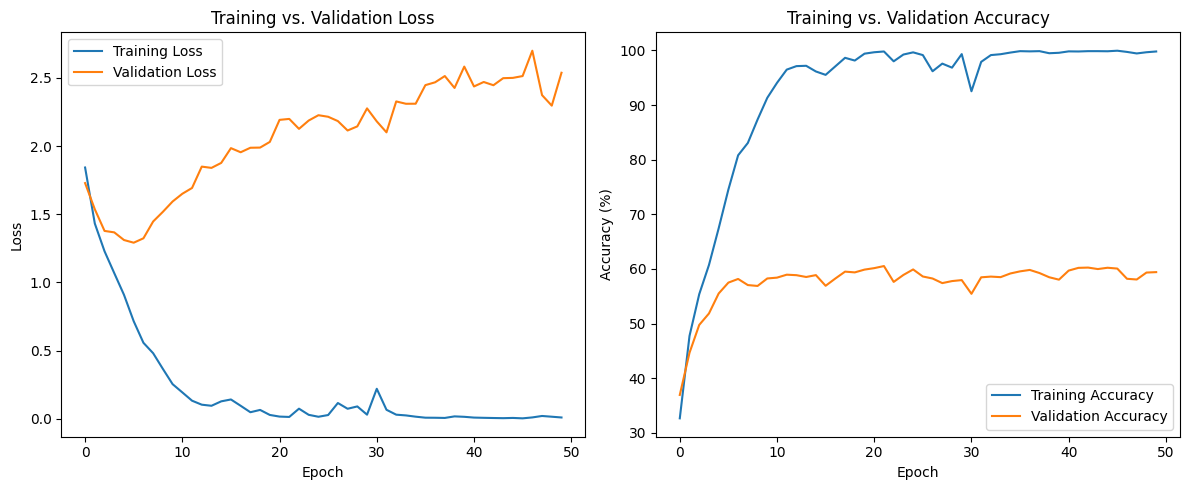

In [13]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

In [14]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in cnn_model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: conv_layer.0.weight, Parameters: 864
Layer: conv_layer.0.bias, Parameters: 32
Layer: conv_layer.1.weight, Parameters: 32
Layer: conv_layer.1.bias, Parameters: 32
Layer: conv_layer.3.weight, Parameters: 9216
Layer: conv_layer.3.bias, Parameters: 32
Layer: conv_layer.6.weight, Parameters: 18432
Layer: conv_layer.6.bias, Parameters: 64
Layer: conv_layer.7.weight, Parameters: 64
Layer: conv_layer.7.bias, Parameters: 64
Layer: conv_layer.9.weight, Parameters: 36864
Layer: conv_layer.9.bias, Parameters: 64
Layer: fc_layer.1.weight, Parameters: 2097152
Layer: fc_layer.1.bias, Parameters: 512
Layer: fc_layer.3.weight, Parameters: 5120
Layer: fc_layer.3.bias, Parameters: 10

Total number of parameters: 2168554


## Fine-Tuning ResNet 
Fine-tuning a pre-trained model for a specific task like CIFAR-10 image classification represents a powerful strategy in Deep Learning:

- ResNet models pre-trained on ImageNet have learned to recognize a wide variety of features. By starting from these learned parameters, the model can leverage this knowledge, which is particularly beneficial when the dataset is relatively small or when computational resources are limited;
- While the pre-trained ResNet is knowledgeable about many features, fine-tuning allows it to adapt this knowledge to the specifics of the new task.
- Fine-tuning a pre-trained model can be more efficient than training a network from scratch, both in terms of computational resources and time required. Additionally, it often leads to better performance, as the model can build upon the complex patterns it has already learned.
- ResNet architectures incorporate residual connections to mitigate the vanishing gradient problem, allowing effective training of deeper networks. This architectural advantage makes ResNets a strong foundation for building high-performance models.

In [15]:
class FineTuneResNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.2):
        super(FineTuneResNet, self).__init__()
        # Load a pre-trained ResNet
        self.resnet = models.resnet18(pretrained=True)
        
        # Remove the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the last fully connected layer
        
        # Define the new fully connected layer
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_ftrs, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # Forward through the ResNet layers
        x = self.resnet(x)
        # Forward through the new fully connected layer
        x = self.fc_layer(x)
        return x

finetuned_resnet = FineTuneResNet().to(device)
print(finetuned_resnet)

C:\Users\matte\miniconda3\envs\jads_bootcamp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\matte\miniconda3\envs\jads_bootcamp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FineTuneResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

<span style="font-size:smaller;">

#### Code Breakdown

Let's explore how to fine-tune a pre-trained model, specifically ResNet, originally trained on a large dataset

```python
class FineTuneResNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(FineTuneResNet, self).__init__()
        ...
```

- **Initialization:** The `FineTuneResNet` class inherits from `nn.Module`. During initialization, it accepts the number of classes for the new task and a dropout rate, setting the stage for the fine-tuning process.

```python
self.resnet = models.resnet18(pretrained=True)
self.resnet.fc = nn.Identity()  # Remove the last fully connected layer
```

- **Load Pre-Trained ResNet:** We begin by loading a pre-trained ResNet-18 model. The `pretrained=True` parameter ensures the model comes with weights learned on the ImageNet dataset, providing a robust feature extractor out of the box.

- **Modifying the Network:** The original fully connected (FC) layer of ResNet, designed for 1000-class ImageNet classification, is replaced with an `nn.Identity()` layer, effectively removing it from the model. This allows us to append custom layers tailored to our specific classification task.

```python
num_ftrs = self.resnet.fc.in_features
self.fc_layer = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, num_classes)
)
```

- **Custom Classification Layer:** We define a new sequence of layers to replace the original ResNet FC layer. This includes a dropout layer for regularization, a linear layer to reduce dimensionality to 128, a ReLU activation, and finally, another linear layer mapping to the number of target classes (`num_classes`).

```python
def forward(self, x):
    x = self.resnet(x)
    x = self.fc_layer(x)
    return x
```

- **Data Flow:** In the `forward` method, input data `x` first passes through the modified ResNet, extracting high-level features. These features are then processed by our custom FC layer, resulting in the final class predictions.

</span>

In [16]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in finetuned_resnet.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: resnet.conv1.weight, Parameters: 9408
Layer: resnet.bn1.weight, Parameters: 64
Layer: resnet.bn1.bias, Parameters: 64
Layer: resnet.layer1.0.conv1.weight, Parameters: 36864
Layer: resnet.layer1.0.bn1.weight, Parameters: 64
Layer: resnet.layer1.0.bn1.bias, Parameters: 64
Layer: resnet.layer1.0.conv2.weight, Parameters: 36864
Layer: resnet.layer1.0.bn2.weight, Parameters: 64
Layer: resnet.layer1.0.bn2.bias, Parameters: 64
Layer: resnet.layer1.1.conv1.weight, Parameters: 36864
Layer: resnet.layer1.1.bn1.weight, Parameters: 64
Layer: resnet.layer1.1.bn1.bias, Parameters: 64
Layer: resnet.layer1.1.conv2.weight, Parameters: 36864
Layer: resnet.layer1.1.bn2.weight, Parameters: 64
Layer: resnet.layer1.1.bn2.bias, Parameters: 64
Layer: resnet.layer2.0.conv1.weight, Parameters: 73728
Layer: resnet.layer2.0.bn1.weight, Parameters: 128
Layer: resnet.layer2.0.bn1.bias, Parameters: 128
Layer: resnet.layer2.0.conv2.weight, Parameters: 147456
Layer: resnet.layer2.0.bn2.weight, Parameters: 128
L

Epoch [1/50], Training Loss: 1.4604, Training Accuracy: 48.20%, Validation Loss: 1.1191, Validation Accuracy: 63.20%
Epoch [2/50], Training Loss: 0.8984, Training Accuracy: 70.28%, Validation Loss: 1.3166, Validation Accuracy: 60.97%
Epoch [3/50], Training Loss: 0.6719, Training Accuracy: 77.44%, Validation Loss: 1.1928, Validation Accuracy: 63.69%
Epoch [4/50], Training Loss: 0.5977, Training Accuracy: 80.30%, Validation Loss: 1.4355, Validation Accuracy: 60.57%
Epoch [5/50], Training Loss: 0.6719, Training Accuracy: 78.72%, Validation Loss: 1.1859, Validation Accuracy: 64.47%
Epoch [6/50], Training Loss: 0.4069, Training Accuracy: 87.16%, Validation Loss: 1.3141, Validation Accuracy: 63.40%
Epoch [7/50], Training Loss: 0.4232, Training Accuracy: 86.74%, Validation Loss: 1.2400, Validation Accuracy: 66.65%
Epoch [8/50], Training Loss: 0.4141, Training Accuracy: 87.26%, Validation Loss: 1.1237, Validation Accuracy: 68.53%
Epoch [9/50], Training Loss: 0.2267, Training Accuracy: 93.16%, 

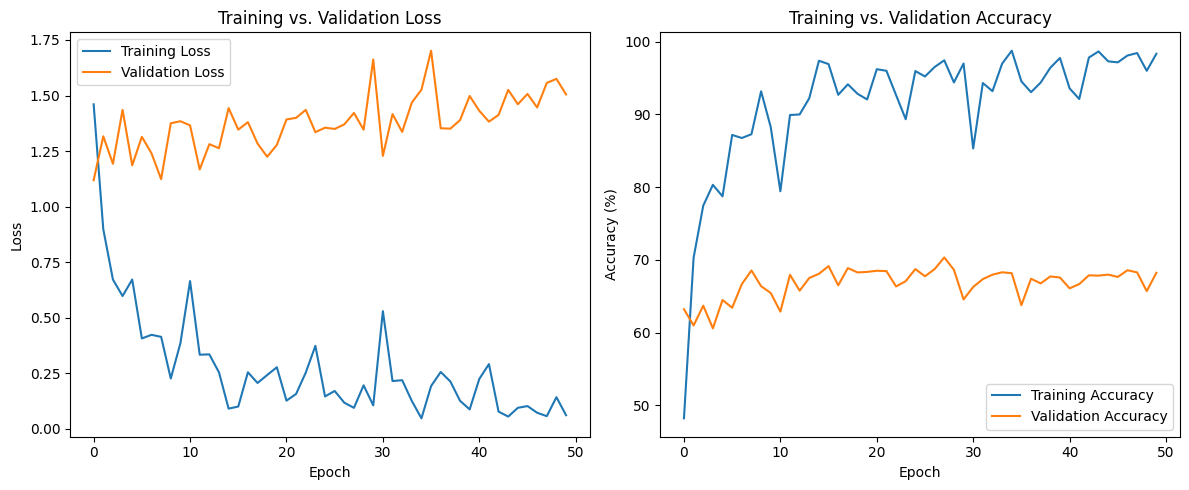

In [17]:
model = FineTuneResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

## Data Augmentation

In [18]:
# Enhanced augmentation + normalization for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Randomly crop the images and pad the borders
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize images
])

# Only normalization for testing, no augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize images
])

# CIFAR10 datasets with transformations
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

print(f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Full train set size: 50000 - Reduced train set size: 5000 - Test set size: 10000


<span style="font-size:smaller;">

#### Code Breakdown
Let's enhance the model's generalization capabilities by introducing training data variability.

```python
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    ...
    transforms.Normalize(mean=mean, std=std)  # Normalize images
])
```

- **Diverse Augmentations:** The `train_transform` employs a series of augmentation techniques, including random flips, crops, rotations, color jitters, affine translations, and even Gaussian blur. These augmentations artificially expand the dataset by introducing a variety of realistic modifications, helping the model learn from a broader set of data variations and improving its robustness to unseen data.

- **Normalization:** After the augmentation steps, `transforms.ToTensor()` converts the images to PyTorch tensors and apply Standard Normalization, which aids in stabilizing the training process.

```python
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
```

- **Consistent Test Data Processing:** For testing, we skip the augmentation steps to evaluate the model on unaltered images, mirroring real-world scenarios. However, normalization remains crucial to align the test data distribution with the transformed training data.

</span>

Epoch [1/50], Training Loss: 1.6228, Training Accuracy: 43.12%, Validation Loss: 1.4766, Validation Accuracy: 50.19%
Epoch [2/50], Training Loss: 1.1758, Training Accuracy: 60.16%, Validation Loss: 1.2264, Validation Accuracy: 59.80%
Epoch [3/50], Training Loss: 1.1450, Training Accuracy: 60.86%, Validation Loss: 1.3492, Validation Accuracy: 58.12%
Epoch [4/50], Training Loss: 0.9809, Training Accuracy: 66.76%, Validation Loss: 1.0963, Validation Accuracy: 64.39%
Epoch [5/50], Training Loss: 0.9831, Training Accuracy: 66.52%, Validation Loss: 1.0199, Validation Accuracy: 66.55%
Epoch [6/50], Training Loss: 0.8478, Training Accuracy: 71.88%, Validation Loss: 0.9828, Validation Accuracy: 68.49%
Epoch [7/50], Training Loss: 0.7860, Training Accuracy: 73.88%, Validation Loss: 1.1285, Validation Accuracy: 65.12%
Epoch [8/50], Training Loss: 0.8513, Training Accuracy: 71.52%, Validation Loss: 0.9150, Validation Accuracy: 69.48%
Epoch [9/50], Training Loss: 0.7484, Training Accuracy: 74.62%, 

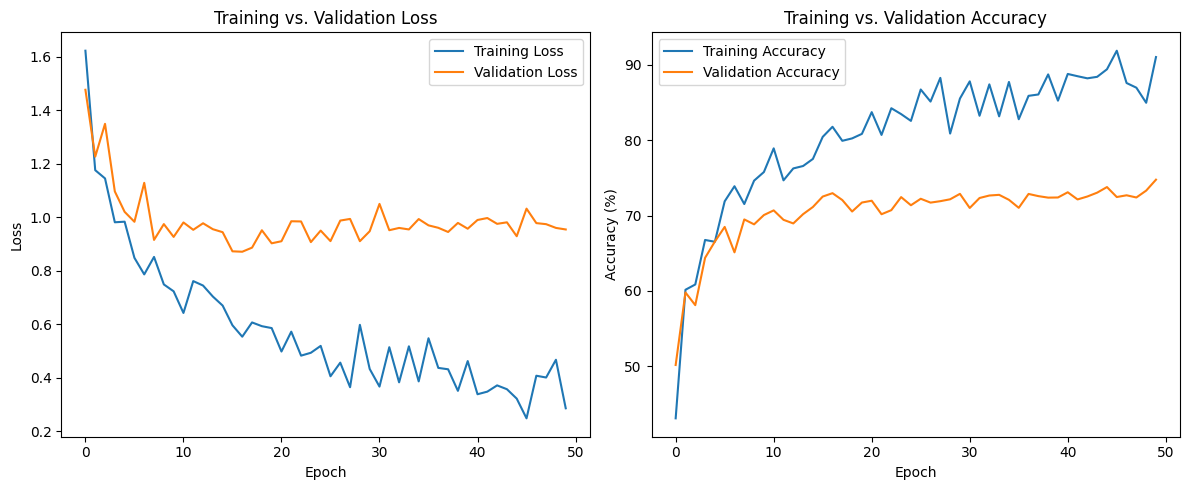

In [19]:
model = FineTuneResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)